# はじめに
このNotebookは、[Stacked Regressions : Top 4% on LeaderBoard](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard)を参考に作成した日本語のNotebookです。
ところどころ日本語化をはしょってますが、最終的なスコアは↑の参考Notebookと同じになってます。

Kaggle日本語の資料が少ないので勉強がてら作ってみたNotebookになります。参考になれば幸いです。

# 0．準備（ライブラリ読み込み、データ読み込み）

In [1]:
# ライブラリの読み込み
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# 学習データとテストデータの読み込み
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

In [3]:
# 学習データの最初の5行を表示
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# 学習データの最初の5行を表示
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# Id列削除前の型を確認
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

# Idだけ別に保持する
train_ID = train['Id']
test_ID = test['Id']

# 予測に不要なのでId列を削除する
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# Id列削除後の型を確認
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


# 1．データ処理
## 1．1．外れ値を除去

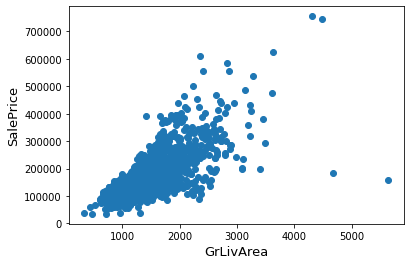

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

GrLivArea（地上の住居面積）が大きいのに、SalePrice（販売価格）が異常に安いデータが2点ある。この2点は異常値とみなして除去するとする。

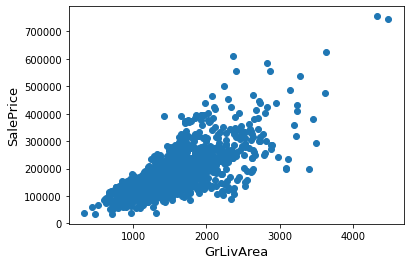

In [7]:
# 外れ値を除去する
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# グラフで表示して再度チェックする
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

## 1．2．目的変数（SalePrice）を分析する

mu = 180932.92 and sigma = 79467.79
※muは、中央値。 sigmaは、分散値


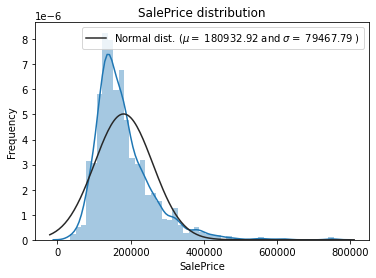

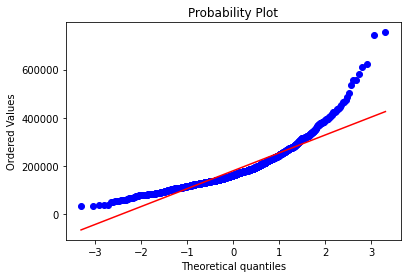

In [8]:
# 正規分布付きのヒストグラムを描画する
sns.distplot(train['SalePrice'] , fit=norm);

# MLE(Maximum Likelihood Estimate)を用いて分布を推定する
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print('※muは、中央値。 sigmaは、分散値')

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQプロットを描画する
# 正規QQプロットとは、観測値が正規分布に従う場合の期待値をY軸にとり、観測値そのものをX軸にとった確率プロット。
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

* 目的変数は、右側に歪んでいる。
* 目的変数は、正規分布していないとモデルの予測精度に影響がでるため、正規分布にする必要がある。

mu = 12.02 and sigma = 0.40
※muは、中央値。 sigmaは、分散値


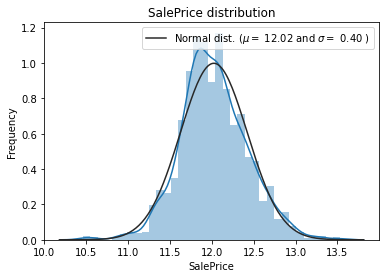

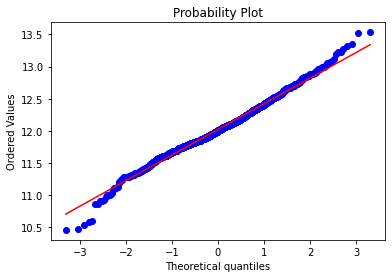

In [9]:
# SalePriceをlog(1+x)　で対数に変換する
train["SalePrice"] = np.log1p(train["SalePrice"])

# 正規分布付きのヒストグラムを描画する
sns.distplot(train['SalePrice'] , fit=norm);

# MLE(Maximum Likelihood Estimate)を用いて分布を推定する
(mu, sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print('※muは、中央値。 sigmaは、分散値')

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# QQプロットを描画する
# 正規QQプロットとは、観測値が正規分布に従う場合の期待値をY軸にとり、観測値そのものをX軸にとった確率プロット。
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

# 2．特徴量の作成
## 2．1．連結データ（all_data）の作成

In [10]:
# 学習データとテストデータを連結して、all_dataを作成する
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


## 2．2．欠損値を確認する

In [11]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'欠損比率' :all_data_na})
missing_data.head(100)

,欠損比率
PoolQC,99.691464
MiscFeature,96.400411
Alley,93.212204
Fence,80.425094
FireplaceQu,48.680151
LotFrontage,16.660953
GarageQual,5.450806
GarageCond,5.450806
GarageFinish,5.450806
GarageYrBlt,5.450806


Text(0.5, 1.0, 'Percent missing data by feature')

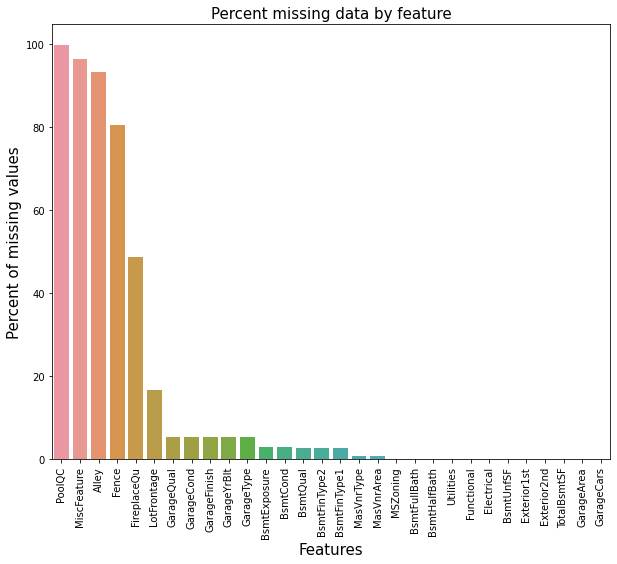

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

## 2．3．相関係数を確認する

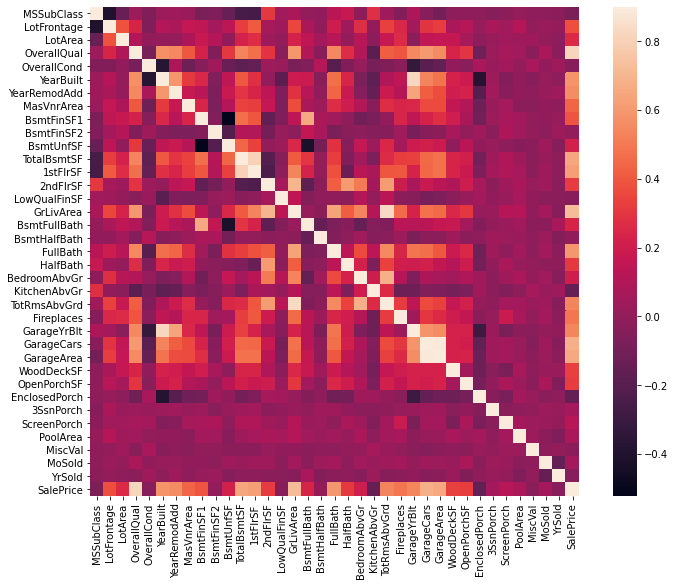

In [13]:
# SalePriceとの相関を確認する
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

## 2．4．欠損値を補完する

* **PoolQC** : プールの品質。NAは「プールなし」ということ。

In [14]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

MiscFeature : 他のカテゴリでカバーされていないその他の機能。NAはその他の機能がないということ。

In [15]:
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

Alley : 住宅から路地へのアクセスタイプ。NAは「路地アクセスなし」ということ。

In [16]:
all_data["Alley"] = all_data["Alley"].fillna("None")

Fence : フェンスの品質。NAは「フェンスなし」ということ。

In [17]:
all_data["Fence"] = all_data["Fence"].fillna("None")

FireplaceQu : 暖炉の品質。NAは「暖炉なし」ということ。

In [18]:
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

LotFrontage : 住居から通りへの距離。近隣と似たような距離の可能性が高いため、近隣のLogFrontageの中央値で欠損値を埋める。

In [19]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

GarageType, GarageFinish, GarageQual and GarageCond : ガレージ。NAは「ガレージなし」ということ。

In [20]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')

GarageYrBlt, GarageArea and GarageCars : ガレージ（数値情報）。NAは「ガレージなし」なので、欠損値には0を埋めるとする。

In [21]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath : 地下。NAは「地下なし」ということ。

In [22]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1 and BsmtFinType2 : 地下。NAは「地下なし」ということ。

In [23]:
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

MasVnrArea and MasVnrType : 石積みベニア。NAには、Noneと0で補完する。

In [24]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

MSZoning : 販売の一般的な種類。欠損値には、最頻値を埋める。

In [25]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

Utilities : ユーティリティ（電気、ガス、水道）のタイプ。数個の「NoSeWa」とNA以外はすべて「AllPub」なので予測に役立たないと判断し、除去する。

In [26]:
all_data = all_data.drop(['Utilities'], axis=1)

Functional : 住宅の機能。93%が「Typ」なので、欠損値も「Typ」で補完する

In [27]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

Electrical : 電気系統。欠損している数は少ないので、最頻値で埋める。

In [28]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

KitchenQual: キッチンの品質。欠損している数は少ないので、最頻値で埋める。

In [29]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

Exterior1st and Exterior2nd : 外装。欠損している数は少ないので、最頻値で埋める。

In [30]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

SaleType : 販売タイプ。欠損している数は少ないので、最頻値で埋める。

In [31]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

欠損値が残ってないかチェックする

In [32]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'欠損比率' :all_data_na})
missing_data.head()

,欠損比率


欠損値は0になった。

## 2．5．カテゴリ変数を適切な形に変換する

カテゴリー的な数値変数を文字列に変換する

In [33]:
# 数字型のカテゴリ変数を、文字列型に変更する
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

カテゴリ変数をラベルエンコーディングする

In [34]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


## 2．6．特徴を追加する

販売価格の予測には、面積関連の特徴が非常に重要なため、地下の総面積、各家の1階と2階の面積である特徴をもう1つ追加する

In [35]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

## 2．7．歪度を調整する

In [36]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("数値型変数の歪度: ")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

数値型変数の歪度: 


,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


歪度の高い変数を、BoxCox変換する。

Box-cox変換：データの構造を無理やり正規分布に変換してくれるらしい。

In [37]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


## 2．8．カテゴリ変数をget dymmyする

In [38]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


新しい学習データとテストデータを取得する

In [39]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# 3．モデリング

## 3．1．準備

必要なライブラリを読み込む。

In [40]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

Sklearnのcross_val_score関数を使用する。ただし、この関数にはシャッフル属性がないため、交差検証の前にデータセットをシャッフルするために、コードを1行追加する。

In [41]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## 3．2．ベースモデルの作成

LASSO Regression（LASSO回帰）：
このモデルは外れ値に非常に敏感である可能性があるため、より堅牢にする必要があります。そのために、パイプラインでsklearnのRobustscaler（）メソッドを使用する。

In [42]:
# LASSO Regression（LASSO回帰）：
# このモデルは外れ値に非常に敏感である可能性があるため、より堅牢にする必要がある。
# そのために、パイプラインでsklearnのRobustscaler（）メソッドを使用する。
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

Elastic Net Regression（Elastic Net 回帰） :
外れ値に対して堅牢にする

In [43]:
# Elastic Net Regression（Elastic Net 回帰） :
# 外れ値に対して堅牢にする
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Kernel Ridge Regression（カーネルリッジ回帰） :

In [44]:
# Kernel Ridge Regression（カーネルリッジ回帰） :
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

Gradient Boosting Regression（勾配ブースティング回帰） :
外れ値に対して、堅牢にするハブ損失

In [45]:
# Gradient Boosting Regression（勾配ブースティング回帰） :
# 外れ値に対して、堅牢にするハブ損失
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

XGBoost :

In [46]:
# XGBoost :
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

LightGBM :

In [47]:
# LightGBM :
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

## 3．3．ベースモデルのスコア
ベースモデルのスコアを確認してみる

In [48]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)


In [49]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)


In [50]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)


In [51]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)


In [52]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Xgboost score: 0.1168 (0.0058)


In [53]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})" .format(score.mean(), score.std()))

LGBM score: 0.1148 (0.0070)


## 3．4．スタッキング（平均化）
シンプルなスタッキング。（ベースモデルを平均化する）

In [54]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

ENet, GBoost, KRR , Lassoの4つのモデルを平均化してスコアをだしてみます。

In [55]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

 Averaged base models score: 0.1091 (0.0075)


## 3．5．スタッキング（メタモデルを追加）
メタモデルを追加したスタッキング。

In [56]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

Enet KRRとGboostを平均化し、次にLassoをメタモデルとして追加してスコアを出してみます。

In [57]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1085 (0.0074)


## 3．6．アンサンブリング
前で定義したStackedRegressorにXGBoostとLightGBMを追加する。

In [58]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

# 4．最終的な学習と予測

StackedRegressor:

In [59]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07803882799654226


XGBoost:

In [60]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07900074237023577


LightGBM:

In [61]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07330605313530042


In [62]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07550082893368715


Ensemble prediction:

In [63]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

# 5．提出

In [64]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)